In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
import keract

2023-05-29 15:49:45.939509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 15:49:46.005451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-29 15:49:46.005468: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-29 15:49:46.328445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

2023-05-29 15:43:33.883221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 15:43:33.883422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-29 15:43:33.883465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-29 15:43:33.883498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-29 15:43:33.883529: W tensorflow/c

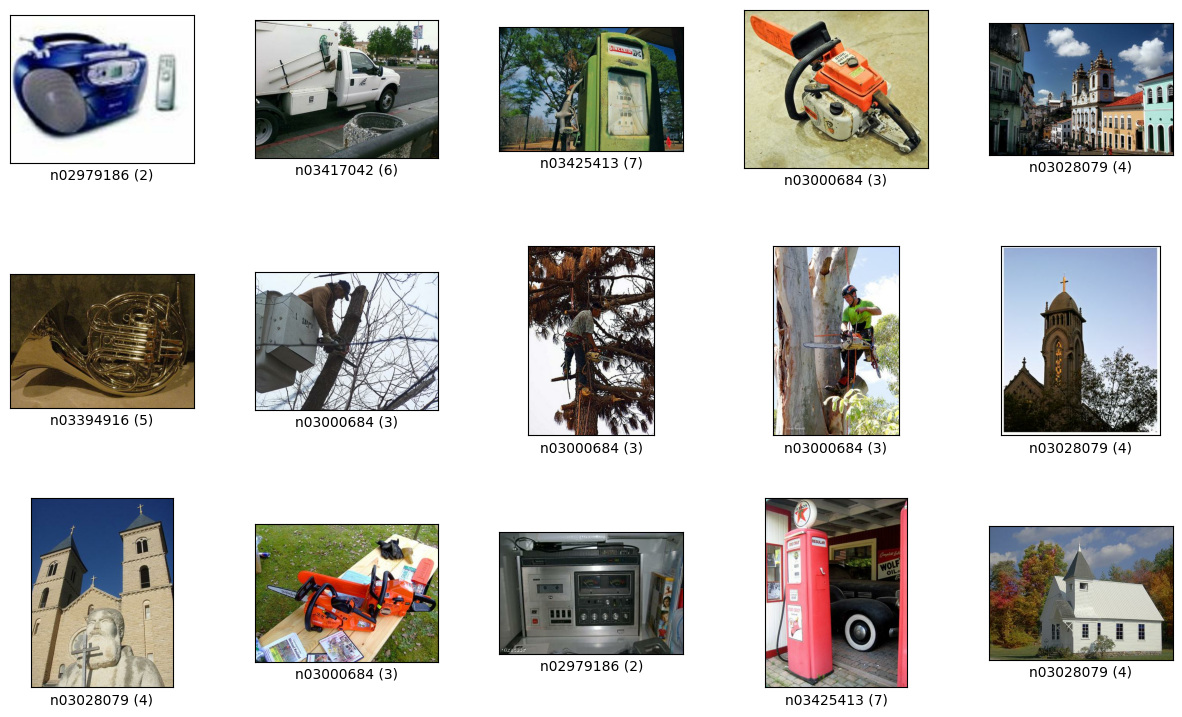

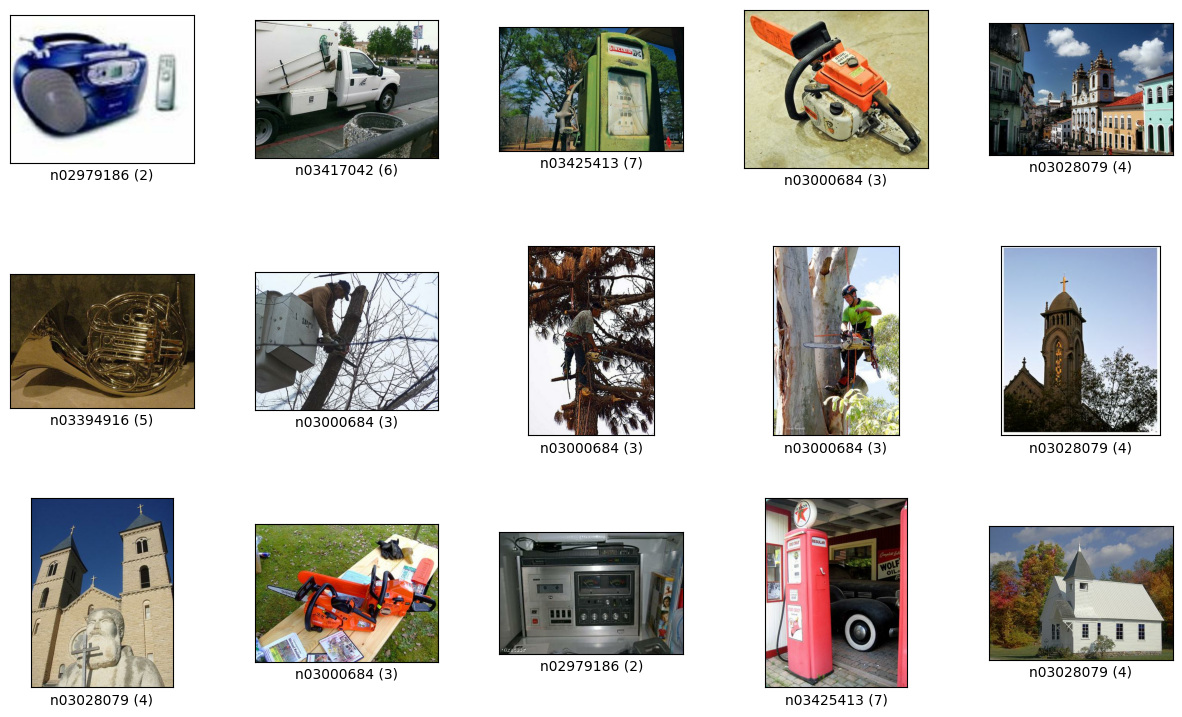

In [2]:
imagenette, imagenette_info = tfds.load(
    'imagenette/320px-v2', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/SSD Games/Tensorflow/tensorflow_datasets',
)

tfds.show_examples(imagenette['train'], imagenette_info, cols=5)

2023-05-29 15:49:47.729906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 15:49:47.730076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-29 15:49:47.730111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-29 15:49:47.730150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-29 15:49:47.730178: W tensorflow/c

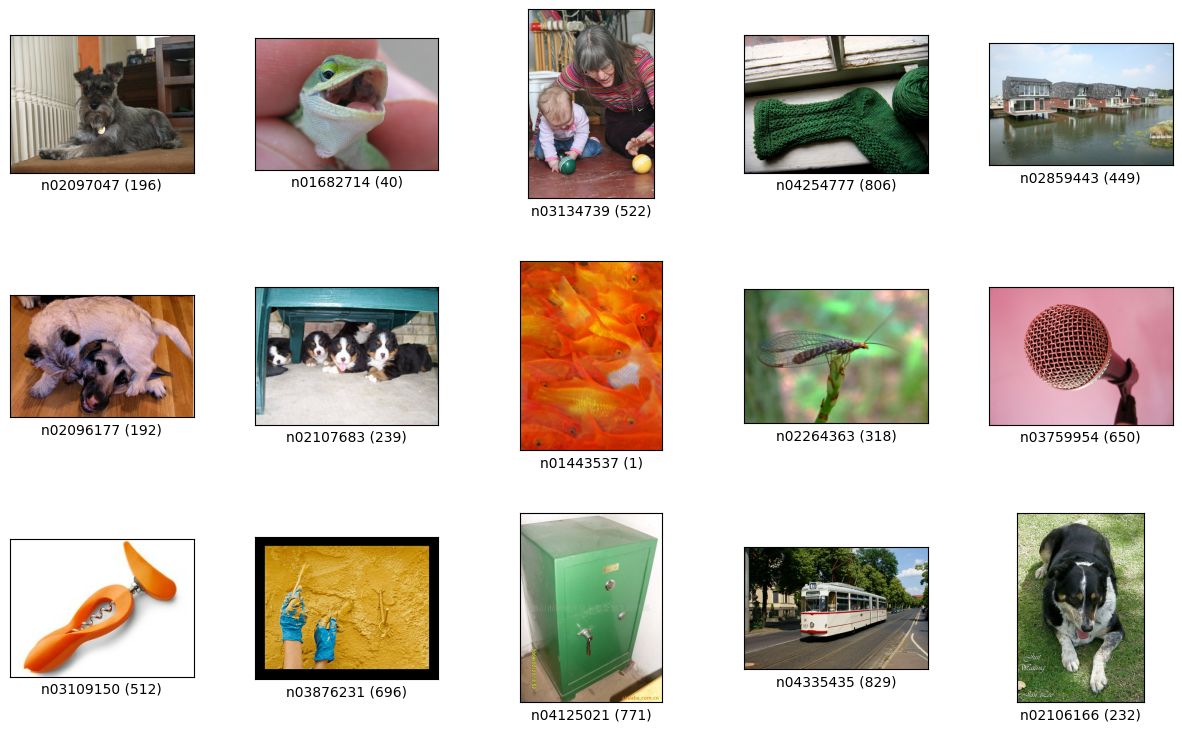

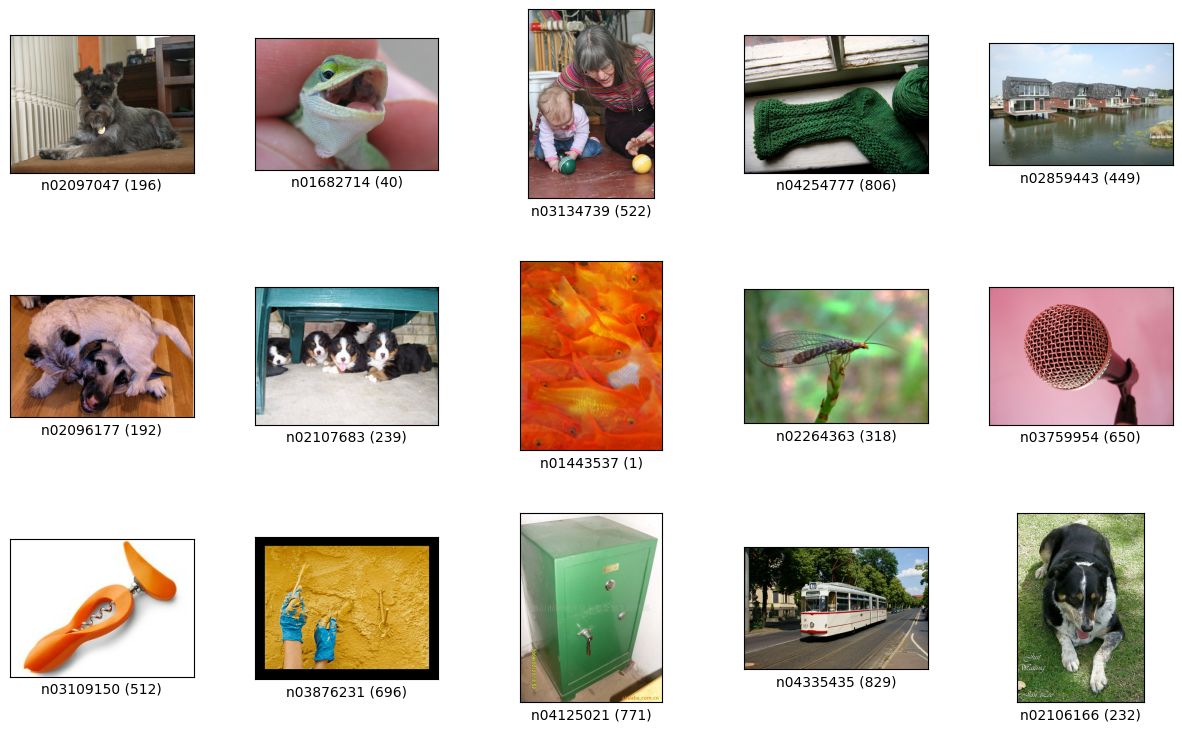

In [2]:
imagenet, imagenet_info = tfds.load(
    'imagenet2012', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/SSD Games/Tensorflow/tensorflow_datasets'
)

tfds.show_examples(imagenet['train'], imagenet_info, cols=5)

In [3]:
vgg = tf.keras.applications.vgg16.VGG16(
    weights='imagenet'
)

vgg.compile(loss="categorical_crossentropy", optimizer="adam")

In [4]:
# ds, ds_info = imagenette['train'], imagenette_info
ds, ds_info = imagenet['train'], imagenet_info
model = vgg

In [5]:
vgg_input_shape = tf.keras.applications.vgg16.VGG16().input.shape[1:3].as_list()
def preprocess_vgg(x, y):
    x = tf.image.resize(x, vgg_input_shape, method=tf.image.ResizeMethod.BILINEAR)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x, y

inception_input_shape = tf.keras.applications.inception_v3.InceptionV3().input.shape[1:3].as_list()
def preprocess_inception(x, y):
    x = tf.image.resize(x, inception_input_shape, method=tf.image.ResizeMethod.BILINEAR)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x, y
    
preprocess = preprocess_vgg
            
def summary_fn_image(x): return np.linalg.norm(
    x, axis=tuple(range(1, len(x.shape)-1)), ord=2)

def summary_fn_dense(x): return x

layers = list(map(lambda l: l.name, filter(lambda l: isinstance(l, (
    # tf.keras.layers.InputLayer,
    tf.keras.layers.Conv2D,
    tf.keras.layers.Dense,
    tf.keras.layers.Flatten,
    tf.keras.layers.Concatenate,
)), model.layers)))

print("Saving these layers only: ", layers)

BATCH_SIZE = 64
total = ds.cardinality().numpy()//BATCH_SIZE

labels = None
activationSummary = {}
i = 0
for img, label in tqdm(ds.map(
        lambda img, label: preprocess(img, label)
    ).batch(
        BATCH_SIZE
    ), total=total):

    if labels is None:
        labels = label.numpy()
    else:
        labels = np.concatenate((labels, label.numpy()), axis=0)

    # Get activations
    activation = keract.get_activations(
        model, img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

    for k, v in activation.items():
        if len(v[0].shape) == 1:
            # dense layer
            summary = summary_fn_dense(v)
        elif len(v[0].shape) == 3:
            # Image layer
            summary = summary_fn_image(v)
        if k not in activationSummary:
            activationSummary[k] = summary
        else:
            activationSummary[k] = np.concatenate(
                (activationSummary[k], summary), axis=0)
            
# Save activationSummary and labels
np.savez_compressed('activationSummary_imagenet.npz', **activationSummary)
np.savez_compressed('labels_imagenet.npz', labels=labels)

Saving these layers only:  ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'flatten', 'fc1', 'fc2', 'predictions']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
  0%|          | 27/20018 [32:28<493:24:01, 88.85s/it]

In [ ]:
loaded_activationSummary = np.load('activationSummary_imagenet.npz')
loaded_labels = np.load('labels_imagenet.npz')

print(loaded_activationSummary.files)
print(loaded_labels.files)

FileNotFoundError: [Errno 2] No such file or directory: 'activationSummary_imagenet.npz'